In [1]:
#imports 
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from nltk.corpus import stopwords

from torchvision.models import resnet50, ResNet50_Weights
import torch
import datetime
import re

import sys
sys.path.append('../src')
from utils import Vocabulary, FlickrDataset, CapsCollate, show_image, EncoderDecoder, DecoderRNN
from pylab import rcParams

image_path = "../all_images/Flicker8k_Dataset/" 
train_file_path = '../all_captions/Flickr_8k.trainImages.txt'
captions_path = "../all_captions/Flickr8k.token.txt"
test_file_path = '../all_captions/Flickr_8k.testImages.txt'

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def clean_text(text):
  text = text.lower()
  text = re.sub("[^a-z]+", " ", text)
  text = text.split()
  text = [s for s in text if len(s)> 1]
  text = " ".join(text)
  return text

caption_file = open(captions_path, "r").read()

BATCH_SIZE = 256
NUM_WORKERS = 0
frequency_threshold = 1

transform = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
            )])

toTensor = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor()])

keys = []
caption_list = []

for row in caption_file.split("\n"):
    key = row.split("#")[0].split(".")[0]
    caption = row.split("#")[-1].split("\t")[-1]
    caption = caption.replace('.', '')
    caption = clean_text(caption)

    keys.append(key)
    caption_list.append(caption)

captions = pd.DataFrame(data=zip(keys, caption_list), columns=["image", "caption"])

train_file = open(train_file_path, 'r').read()
train_imgs = [row.split(".")[0] for row in train_file.split("\n")[:-1]]
train_data = captions[captions.image.isin(train_imgs)]
train_data = train_data.reset_index()

test_file = open(test_file_path, 'r').read()
test_imgs = [row.split(".")[0] for row in test_file.split("\n")[:-1]]
test_data = captions[captions.image.isin(test_imgs)]
test_data = test_data.reset_index()

vocab = Vocabulary(frequency_threshold)
vocab.build_vocab(captions.caption.tolist())

test_dataset = FlickrDataset(image_path, test_data, transform=toTensor, vocab=vocab)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=CapsCollate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#len of vocabulary
len(vocab)

8426

In [6]:
embed_size = 300
vocab_size = len(vocab)
attention_dim = 3000    
encoder_dim = 2048
decoder_dim = 3000

model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, device)
model.load_state_dict(torch.load("../models/resnet-101-3000dimensions.pth"))
model.eval()
model.to(device)

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

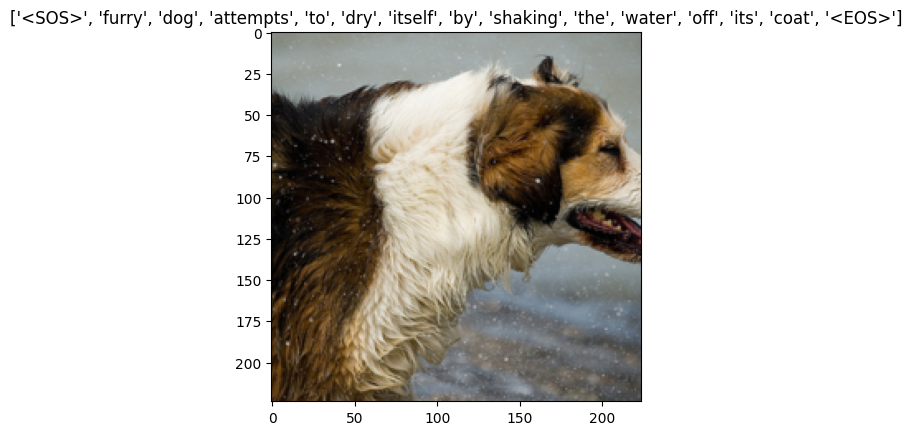

In [7]:
show_image(test_dataset[42][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[42][1]])

In [8]:
features = model.encoder(test_dataset[42][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)

In [9]:
len(alphas), caption

(8, ['white', 'dog', 'with', 'leash', 'running', 'in', 'water', '<EOS>'])

In [10]:
test_dataset[42][0].shape

torch.Size([3, 224, 224])

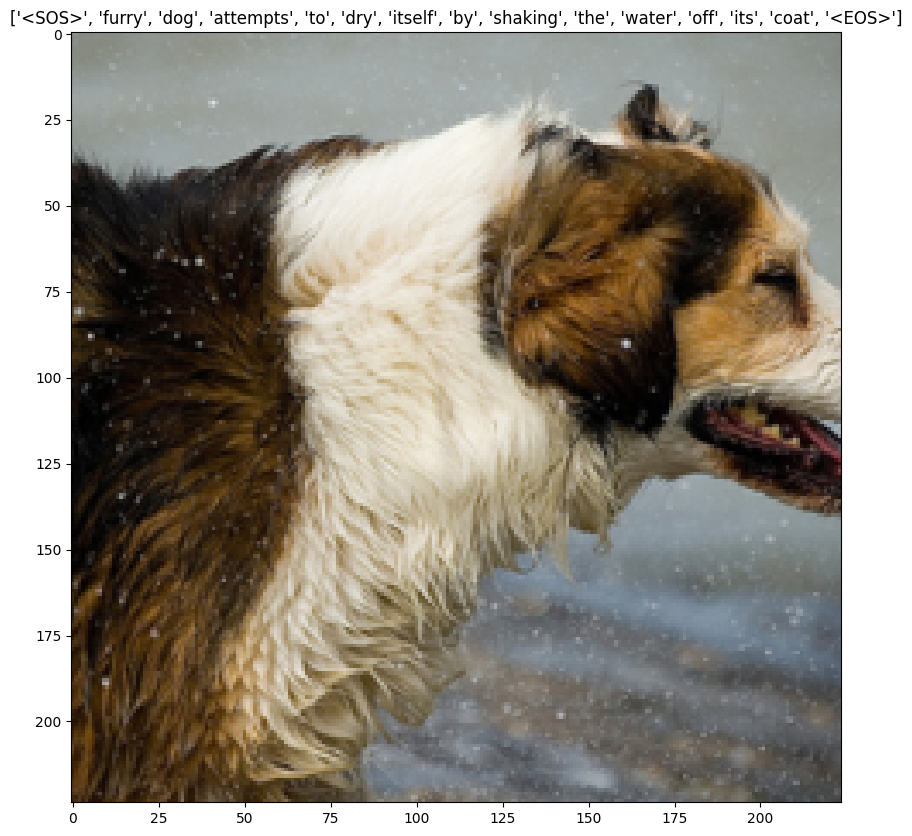

In [11]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[42][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[42][1]])

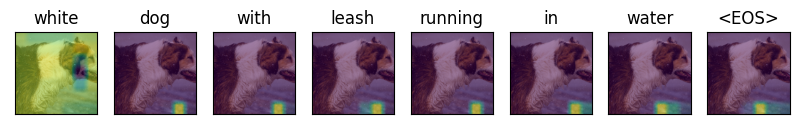

Original Caption:  <SOS> furry dog attempts to dry itself by shaking the water off its coat <EOS>


In [12]:
features = model.encoder(test_dataset[42][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[42][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 20, 40
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[42][1]]))

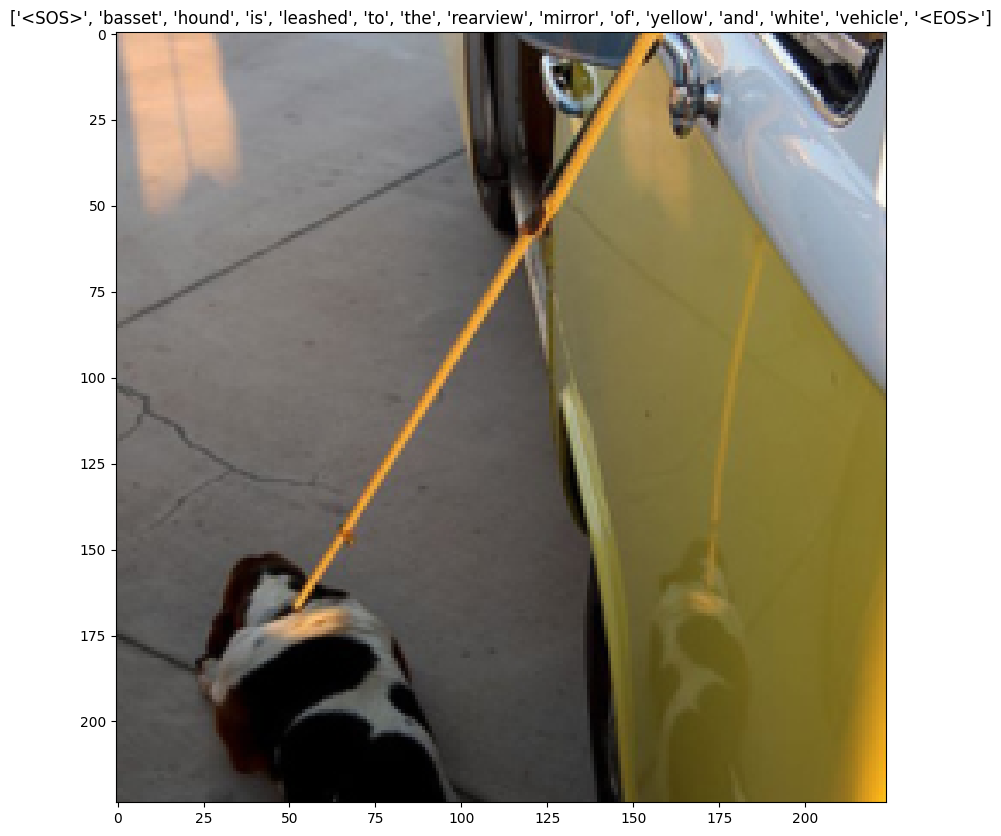

In [13]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[420][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[420][1]])

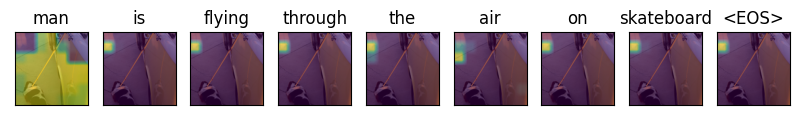

Original Caption:  <SOS> basset hound is leashed to the rearview mirror of yellow and white vehicle <EOS>


In [14]:
features = model.encoder(test_dataset[420][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[420][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 30, 30
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[420][1]]))

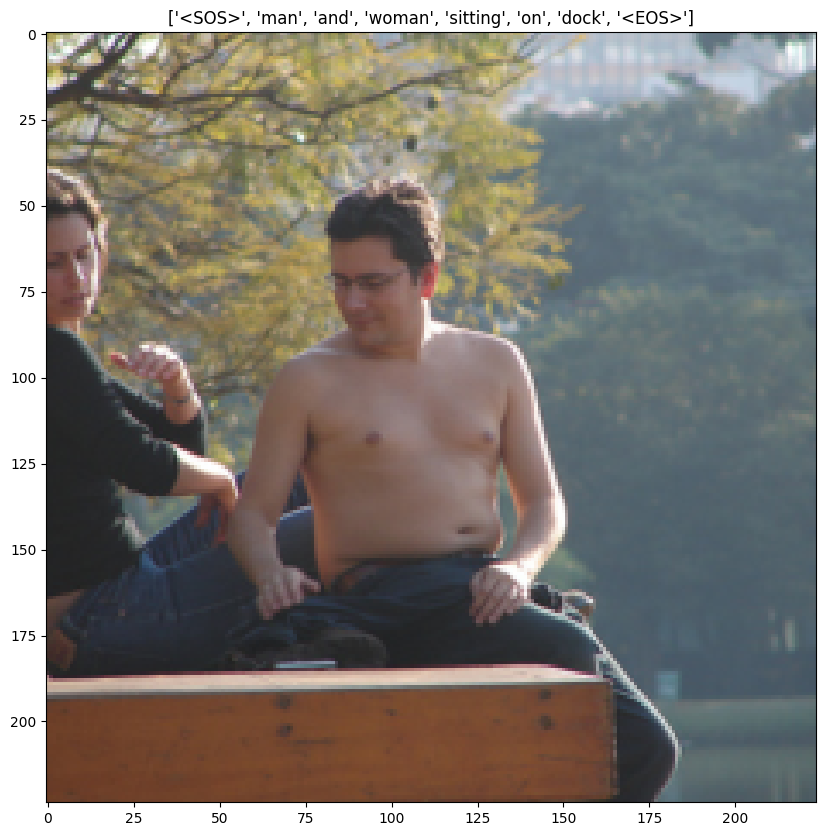

In [15]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[12][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[12][1]])

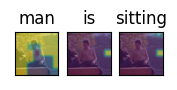

Original Caption:  <SOS> man and woman sitting on dock <EOS>
Generated Caption:  man is sitting on the edge of pool with his shoes in the air <EOS>


In [16]:
features = model.encoder(test_dataset[12][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas) - 12):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[12][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 100, 10
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[12][1]]))
print("Generated Caption: ", " ".join(caption))

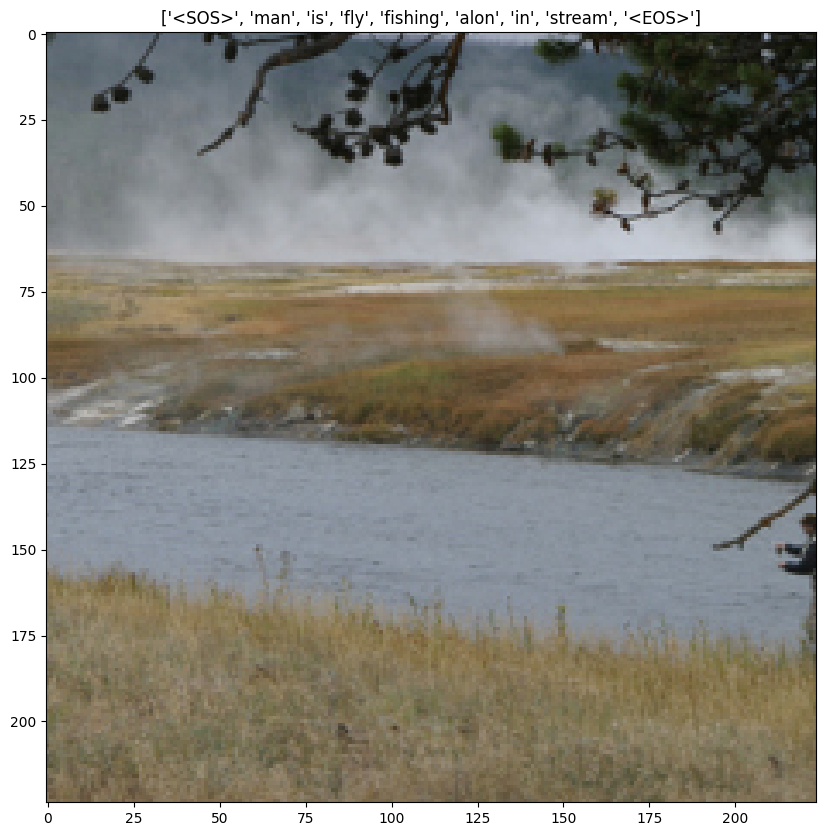

In [17]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[1230][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[1230][1]])

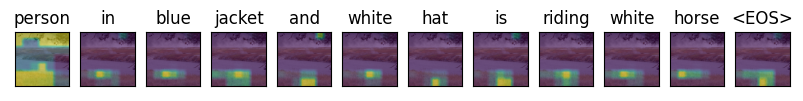

Original Caption:  <SOS> man is fly fishing alon in stream <EOS>
Generated Caption:  person in blue jacket and white hat is riding white horse <EOS>


In [18]:
features = model.encoder(test_dataset[1230][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[1230][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 100, 10
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[1230][1]]))
print("Generated Caption: ", " ".join(caption))

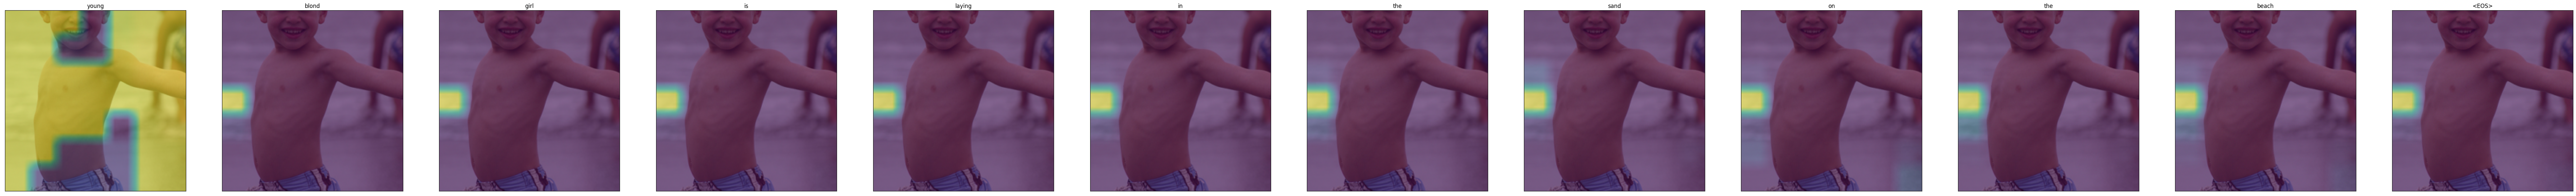

Original Caption:  <SOS> boy in his blue swim shorts at the beach <EOS>
Generated Caption:  young blond girl is laying in the sand on the beach <EOS>


In [19]:
features = model.encoder(test_dataset[5][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[5][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 100, 10
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[5][1]]))
print("Generated Caption: ", " ".join(caption))

## Using bilinear interpolation yields same result as just reshaping and resizing

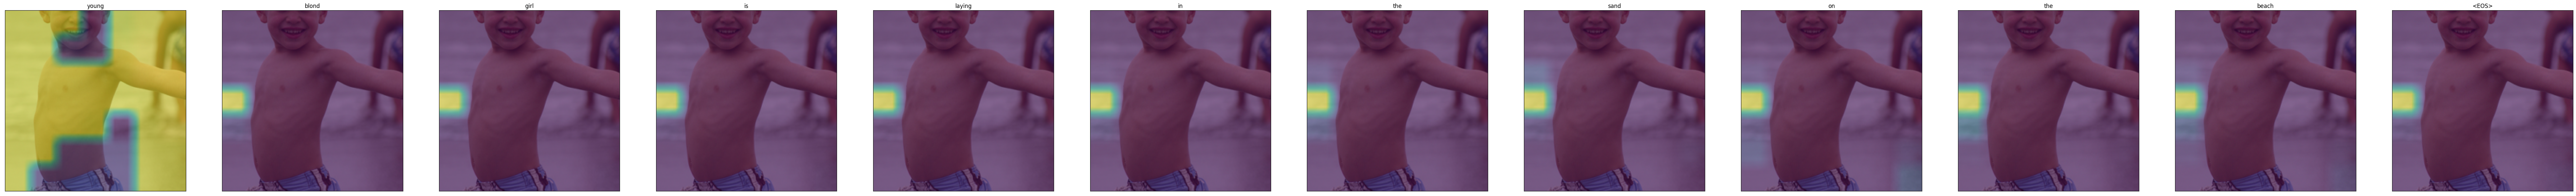

Original Caption:  <SOS> boy in his blue swim shorts at the beach <EOS>
Generated Caption:  young blond girl is laying in the sand on the beach <EOS>


In [20]:
features = model.encoder(test_dataset[5][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = torch.nn.functional.interpolate(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0).unsqueeze(0), size = (224), mode="bilinear").squeeze(0).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[5][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 100, 10
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[5][1]]))
print("Generated Caption: ", " ".join(caption))

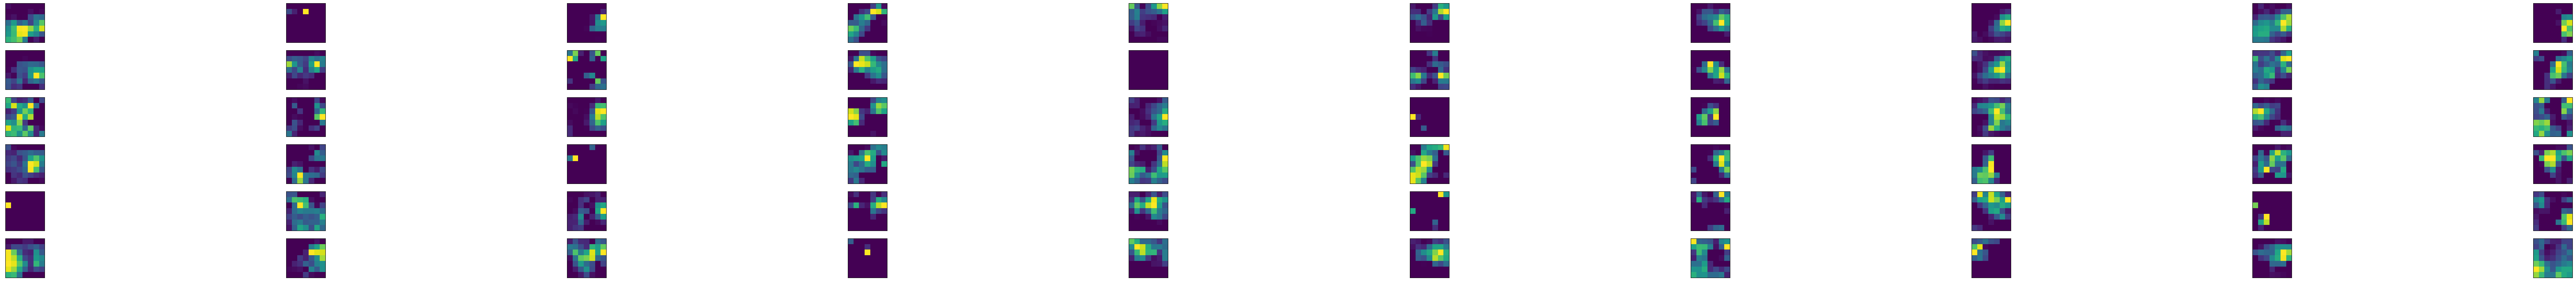

In [21]:
filters = model.encoder.resnet(test_dataset[42][0].unsqueeze(0).to(device))[0, :, :, :].cpu().numpy().transpose((0,1,2))

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 6, 1
for i in range(n_filters):
    for j in range(10):
        # get the filter
        f = filters[ix-1, :, :]
        ax = plt.subplot(n_filters, 10, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :])
        ix += 1
        
rcParams['figure.figsize'] = 100, 10
plt.show()

In [22]:
train_data

,index,image,caption
0,0,1000268201_693b08cb0e,child in pink dress is climbing up set of stai...
1,1,1000268201_693b08cb0e,girl going into wooden building
2,2,1000268201_693b08cb0e,little girl climbing into wooden playhouse
3,3,1000268201_693b08cb0e,little girl climbing the stairs to her playhouse
4,4,1000268201_693b08cb0e,little girl in pink dress going into wooden cabin
...,...,...,...
29995,40450,997338199_7343367d7f,person stands near golden walls
29996,40451,997338199_7343367d7f,woman behind scrolled wall is writing
29997,40452,997338199_7343367d7f,woman standing near decorated wall writes
29998,40453,997338199_7343367d7f,the walls are covered in gold and patterns


In [23]:
train_dog_counter = len(train_data[train_data["caption"].str.contains("[Dd]og")])
test_dog_counter = len(test_data[test_data["caption"].str.contains("[Dd]og")])

In [24]:
print(train_dog_counter)
print(test_dog_counter)
print("percentage of dog in train data: ", train_dog_counter/len(train_data))
print("percentage of dog in test data: ", test_dog_counter/len(test_data))

7153
1120
percentage of dog in train data:  0.23843333333333333
percentage of dog in test data:  0.224


In [25]:
test_dataset.captions[0:8]

0    blond woman in blue shirt appears to wait for ...
1            blond woman is on the street hailing taxi
2    woman is signaling is to traffic as seen from ...
3    woman with blonde hair wearing blue tube top i...
4    the woman in the blue dress is holding out her...
5             boy in his blue swim shorts at the beach
6                   boy smiles for the camera at beach
7    young boy in swimming trunks is walking with h...
Name: caption, dtype: object

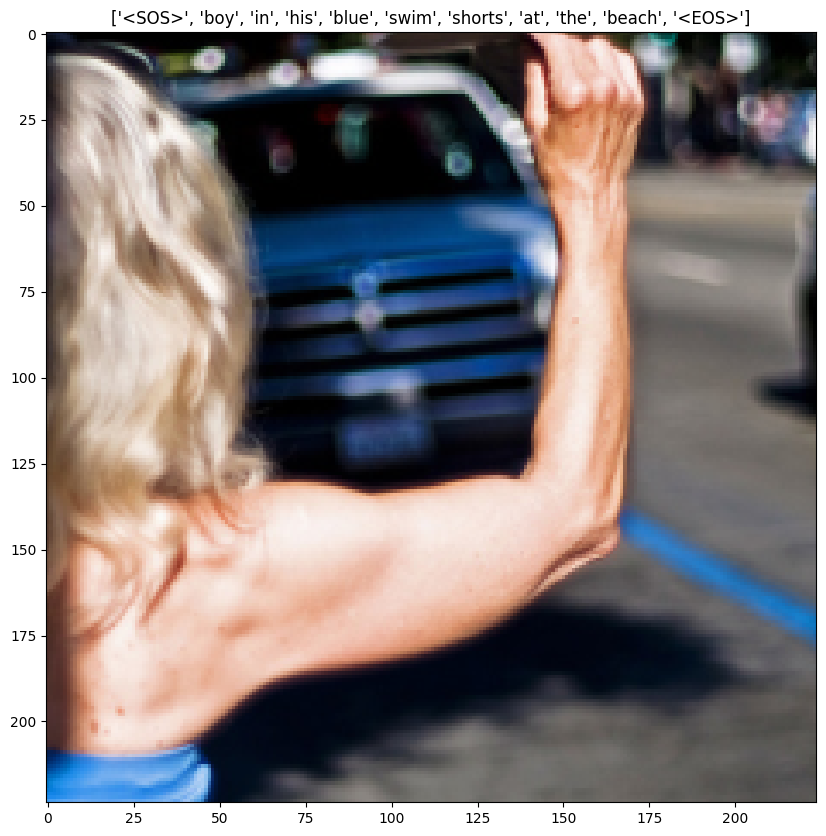

In [26]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[0][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[5][1]])

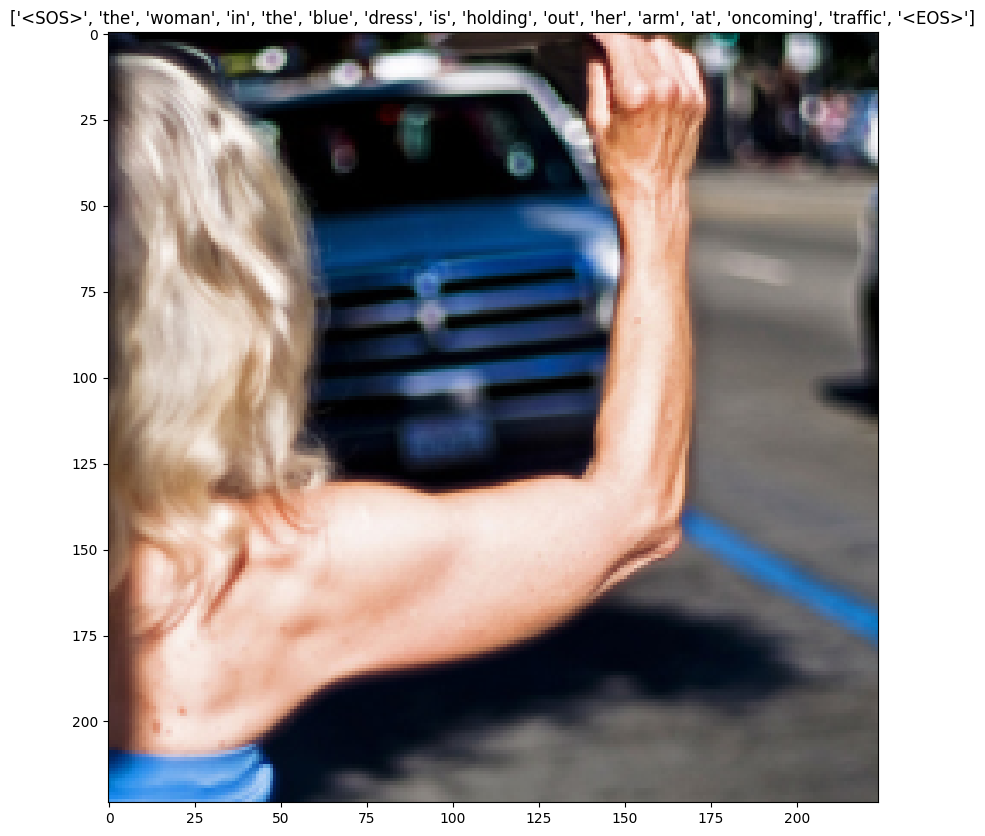

In [27]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[4][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[4][1]])

In [28]:
y_pred = []
y = []
with torch.no_grad():
    for idx in range(0, len(test_dataset), 5):
        features = model.encoder(test_dataset[idx][0].unsqueeze(0).to(device))
        caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
        y_pred.append(caption[0:-1])
        y_hypotheses = []
        for i in range(idx, idx + 5):
            #print(test_dataset.vocab.itos[int(j.numpy())])
            y_hypotheses.append([test_dataset.vocab.itos[int(j.numpy())] for j in test_dataset[i][1][1:-1]])
        y.append(y_hypotheses)
        if idx % 500 == 0:
            print(f"Done {idx} images")


Done 0 images
Done 500 images
Done 1000 images
Done 1500 images
Done 2000 images
Done 2500 images
Done 3000 images
Done 3500 images
Done 4000 images
Done 4500 images


In [29]:
dog_train_set = train_data[train_data["caption"].str.contains("[Dd]og")].reset_index(drop=True)
dog_test_set = test_data[test_data["caption"].str.contains("[Dd]og")].reset_index(drop=True)

dog_test_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", dog_test_set, transform=toTensor, vocab=vocab)
dog_test_dataloader = DataLoader(dog_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=CapsCollate())

y_pred_dog = []
y_dog = []
with torch.no_grad():
    for idx in range(len(dog_test_set)):
        features = model.encoder(dog_test_set[idx][0].unsqueeze(0).to(device))
        caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
        y_pred.append(' '.join(caption[0:-1]))
        y.append(" ".join([test_dataset.vocab.itos[int(i.numpy())] for i in dog_test_set[idx][1]][1:-1]))
        if idx % 500 == 0:
            print(f"Done {idx} images")

KeyError: 0

In [30]:
y_pred[2]

['man',
 'is',
 'sitting',
 'on',
 'the',
 'edge',
 'of',
 'pool',
 'with',
 'his',
 'shoes',
 'in',
 'the',
 'air']

In [31]:
y[2]

[['lady', 'and', 'man', 'with', 'no', 'shirt', 'sit', 'on', 'dock'],
 ['man', 'and', 'woman', 'are', 'sitting', 'on', 'dock', 'together'],
 ['man', 'and', 'woman', 'sitting', 'on', 'dock'],
 ['man', 'and', 'woman', 'sitting', 'on', 'deck', 'next', 'to', 'lake'],
 ['shirtless', 'man', 'and', 'woman', 'sitting', 'on', 'dock']]

## Bleu score

- P = m / w (ratio of candidate words in the reference)
- Unigram precision = Clip(num word matches) / num words in generation
- unigram = 1-gram bleu
- bigram = 2-gram bleu
- trigram = 3-gram bleu and so on...
- from 0 to 1
- If a word is in the wrong place, the meaning changes, bleu doesn't capture this
- More focused on precision

In [32]:
# 1- gram
from nltk.translate.bleu_score import sentence_bleu
score = 0
for i in range(len(y_pred)):
    score += sentence_bleu(y[i], y_pred[i], weights=(1, 0, 0, 0))

print("average 1-gram score: ", score/len(y_pred))

average 1-gram score:  0.388615067842204


c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

In [33]:
# 2- gram
from nltk.translate.bleu_score import sentence_bleu
score = 0
for i in range(len(y_pred)):
    score += sentence_bleu(y[i], y_pred[i], weights=(0, 1, 0, 0))

print("average 2-gram score: ", score/len(y_pred))

average 2-gram score:  0.11275727207585043


In [34]:
# 3 - gram
from nltk.translate.bleu_score import sentence_bleu
score = 0
for i in range(len(y_pred)):
    score += sentence_bleu(y[i], y_pred[i], weights=(0, 0, 1, 0))

print("average 3-gram score: ", score/len(y_pred))

average 3-gram score:  0.03215282103398512


In [35]:
# 4 - gram
from nltk.translate.bleu_score import sentence_bleu
score = 0
for i in range(len(y_pred)):
    score += sentence_bleu(y[i], y_pred[i], weights=(0, 0, 0, 1))

print("average 4-gram score: ", score/len(y_pred))

average 4-gram score:  0.007896302865944197


In [36]:
sentence_bleu(y[0], y_pred[0])

1.2882297539194154e-231

In [37]:
y_pred[0]

['white',
 'dog',
 'is',
 'running',
 'through',
 'the',
 'sand',
 'with',
 'red',
 'collar',
 'and',
 'ball']

In [38]:
import spacy
nlp = spacy.load('en_core_web_sm')

similarities = 0

for i in range(len(y_pred)):
    similarities += nlp(' '.join(y_pred[i])).similarity(nlp(' '.join(y[i])))
    
print(similarities/len(y_pred))

TypeError: sequence item 0: expected str instance, list found